In [10]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import poppy
import astropy.units as u
import logging
logging.basicConfig(level=logging.DEBUG)
from astropy.io import fits
from astropy.modeling import models, fitting
import tifffile
import numpy as np
import matplotlib.colors as mcolors
from astropy.stats import sigma_clip
logging.getLogger().setLevel(logging.INFO)
import photutils
import time
import datetime as dt
from numpy.linalg import lstsq
import os
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import os, re
from poppy.zernike import zernike_basis,decompose_opd
import winsound
from poppy.zernike import noll_indices, zern_name
from astropy.table import Table
import glob

# Colormap
dark_yellow = [ '#003f5c', '#2f4b7c', '#665191', '#a05195', '#d45087', '#f95d6a', '#ff7c43', '#ffa600']
custom_cmap = mcolors.LinearSegmentedColormap.from_list("DarkYellow", dark_yellow)
gradient = np.linspace(0, 1, 256).reshape(1, -1)


<span style="color:green; font-size: 2.5em;">Funzioni</span>


In [5]:

##########################################################################
##########################################################################
def parse_beam_center(fn):
    bx = by = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Beam Center X [mm]' in L:
                bx = float(L.split(',')[1])
            elif 'Beam Center Y [mm]' in L:
                by = float(L.split(',')[1])
            if bx is not None and by is not None:
                break
    if bx is None or by is None:
        raise RuntimeError("Beam center not found")
    return bx, by
##########################################################################
##########################################################################
def parse_wavefront_grid(filename):
    with open(filename, 'r', encoding='latin-1') as f:
        lines = f.readlines()
    x_coords_line = None
    for i, line in enumerate(lines):
        if line.strip().startswith("y / x [mm]"):
            x_coords_line = i
            break
    if x_coords_line is None:
        raise ValueError("X coordinates line not found")
    x_coords_str = lines[x_coords_line].split(",")[1:]
    x_coords = []
    for x in x_coords_str:
        x_clean = x.strip()
        try:
            x_coords.append(float(x_clean))
        except:
            x_coords.append(np.nan) 
    y_coords = []
    wavefront_data = []
    for line in lines[x_coords_line+1:]:
        if line.strip() == "":
            continue
        parts = line.split(",")
        if len(parts) < 2:
            continue
        y_str = parts[0].strip()
        try:
            y = float(y_str)
        except:
            continue 
        vals = []
        # Keep all columns aligned with x_coords
        for v in parts[1:]:
            v_clean = v.strip()
            try:
                vals.append(float(v_clean))
            except:
                vals.append(np.nan)  
        y_coords.append(y)
        wavefront_data.append(vals)
    wf_array = np.array(wavefront_data)
    y_coords = np.array(y_coords)
    x_coords = np.array(x_coords)
    #print(f"x_coords length: {len(x_coords)}")
    #print(f"wavefront_data shape: {wf_array.shape}")
    if wf_array.shape[1] != len(x_coords):
        raise ValueError("Mismatch between wavefront columns and x coordinates")
    return x_coords, y_coords, wf_array
##########################################################################
##########################################################################
def parse_zernike_coeffs(fn, n_modes):
    coeffs = []
    in_z = False
    pat = re.compile(r'\s*(\d+),\s*-?\d+,\s*-?\d+,\s*([-\d\.eE]+)')
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if L.strip().startswith('*** ZERNIKE FIT ***'):
                in_z = True
                continue
            if in_z:
                m = pat.match(L)
                if m:
                    idx, c = int(m.group(1)), float(m.group(2))
                    if idx <= n_modes:
                        coeffs.append(c)
                if len(coeffs) >= n_modes:
                    break
    return np.array(coeffs)
##########################################################################
##########################################################################

##########################################################################
##########################################################################
def remap_sensor_coeffs(raw, n_modes):
    rem = np.zeros(n_modes)
    for i, c in enumerate(raw, start=1):
        tgt = {2:3, 3:2}.get(i, i)
        if tgt <= n_modes:
            rem[tgt-1] = c
    return rem
##########################################################################
##########################################################################
def parse_pupil_diameter_center(fn):
    pd = None
    pcx = None
    pcy = None
    with open(fn, 'r', encoding='latin-1') as f:
        for L in f:
            if 'Pupil Diameter X [mm]' in L:
                pd = float(L.split(',')[1])
            elif 'Pupil Center X [mm]' in L:
                pcx = float(L.split(',')[1])
            elif 'Pupil Center Y [mm]' in L:
                pcy = float(L.split(',')[1])
    if pd is None or pcx is None or pcy is None:
        raise RuntimeError("Pupil diameter or center not found")
    #print(f"Pupil diameter: {pd} mm, Center: ({pcx}, {pcy}) mm")
    return pd, pcx, pcy
##########################################################################
##########################################################################

##########################################################################
##########################################################################
def fit_zernikes(x_coords, y_coords, wavefront_data, pupil_diameter, max_mode):  # maxmode=15
    # Normalize to unit pupil centered at 
    X_norm = x_coords / (pupil_diameter / 2)
    Y_norm = y_coords / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    wf_masked = wavefront_data[mask]
    basis_stack = zernike_basis(nterms=max_mode, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(max_mode)]).T #Stacks the Zernike modes into a matrix of shape (n_points, n_modes).
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wf_masked, rcond=None)
    # fitted wavefront
    wf_fit = np.full_like(wavefront_data, np.nan)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(max_mode)], axis=0)
    wf_fit[mask] = fit_vals
    return coeffs, wf_fit
#######################################################################
#########################################################################
song_jojo = "B4 B4 B4 A4 B4 D5 B4 A4 B4 B4 B4 A4 B4 F4 E4 D4"
song_shrek = "C R G E E R D C C F R E E D D C"
def musichetta(song):
    base_freq = 440  # A4
    ratio = 2 ** (1/12)  # precise semitone ratio
    base_note_index = {'C': -9, 'C#': -8, 'D': -7, 'D#': -6, 'E': -5,
                       'F': -4, 'F#': -3, 'G': -2, 'G#': -1, 'A': 0,
                       'A#': 1, 'B': 2}

    def get_freq(note_with_octave):
        if note_with_octave == 'R':
            return None
        note = ''.join(filter(str.isalpha, note_with_octave))
        accidental = '#' if '#' in note_with_octave else ''
        octave = int(''.join(filter(str.isdigit, note_with_octave)) or 4)
        semitone_offset = base_note_index.get(note + accidental, 0)
        n = semitone_offset + (octave - 4) * 12
        return int(base_freq * (ratio ** n))

    def play_note(note, duration=250):
        freq = get_freq(note)
        if freq:
            winsound.Beep(freq, duration)
        else:
            time.sleep(duration / 1000)

    for note in song.split():
        play_note(note)
##########################################################################
##########################################################################
def data_loading(file):
    match = re.search(r'elev(\d{2})', file)
    if match:
       elevation = int(match.group(1))
       #print(f"Elevation extracted: {elevation}")
    else:
       raise ValueError(f"Elevation not found in file name: {file}")
    x_coords, y_coords, wavefront_data = parse_wavefront_grid(file)
    pupil_diameter, pupil_center_x, pupil_center_y = parse_pupil_diameter_center(file)
    return x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation
#########################################################################
##########################################################################
def zernike_wfe_analysis(file,n_modes,exclude_low):
    results_single_file=[]
    x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, _ = data_loading(file)
    # griglia
    X_norm = (x_coords-pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords-pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    # Zernike basis 
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    # fit coefficienti
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs, _, _, _ = np.linalg.lstsq(Z_mat, wavefront_data[mask], rcond=None)
    # fitted wavefront
    #wavefront_total = np.full_like(wavefront_data, np.nan)   # PER METTERE I NAN INVECE DEGLI ZERO
    wavefront_total = np.zeros_like(wavefront_data)
    fit_vals = np.sum([coeffs[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_total[mask] = fit_vals
    ########################################################################################
    #for i, c in enumerate(coeffs, 0):
    #    print(f"Mode {i}: {c:.6f} ")#µm"
    #SOTTRAZIONE PRIMI TERMINI #############
    wf_low = np.zeros_like(wavefront_data)
    for j in range(exclude_low):
        wf_low[mask] += coeffs[j] * basis_stack[j][mask]
    wf_high = wavefront_total - wf_low

    # risultati
    residuals_total = wavefront_data - wavefront_total
    residuals_low = wavefront_data - wf_low
    residuals_high = wavefront_data - wf_high
    rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
    pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)
    
    results_single_file = {
        'filename': file,
        'rms_wfe': rms_wfe,
        'pv_wfe': pv_wfe,
        'coeffs': coeffs,
        'residuals_total': residuals_total,
        'residuals_low': residuals_low,
        'residuals_high': residuals_high,
        'wavefront_total': wavefront_total,
        'wavefront_low': wf_low,
        'wavefront_high': wf_high,
        'wavefront_measured': wavefront_data
    }
    return [results_single_file]
#################################################################################
#####################################################################################à
def save_wavefront_cube(wf_list, filenames, out_fits, extname_prefix):
    """
    wf_list: lista di 2D array (Ny,Nx), N_file
    """
    shape0 = wf_list[0].shape
    for arr in wf_list:
        if arr.shape != shape0:
            raise ValueError("Shape diversa tra wavefront")
    cube = np.stack(wf_list, axis=0).astype(np.float32)  # (N,Ny,Nx)
 
    hdu_primary = fits.PrimaryHDU(data=cube)
    hdu_primary.header['COMMENT'] = f"Cube {extname_prefix}: dim (N_files, Ny, Nx)"

    indices = np.arange(len(filenames), dtype=np.int32)
    maxlen = max(len(fn) for fn in filenames)
    col_idx = fits.Column(name='index', format='K', array=indices)
    col_fn  = fits.Column(name='filename', format=f'A{maxlen}', array=np.array(filenames, dtype=f'U{maxlen}'))
    table_hdu = fits.BinTableHDU.from_columns([col_idx, col_fn], name=f'{extname_prefix}_FILES')
    hdul = fits.HDUList([hdu_primary, table_hdu])
    hdul.writeto(out_fits, overwrite=True)
    hdul.close()
###################################################################################
#######################################################################################à
def build_dataframe(results_all, coeffs_mean = None):
    records = []
    for res in results_all:
        rec = {
            'filename': os.path.basename(res['filename']),
            'rms_wfe': res['rms_wfe'],
            'pv_wfe': res['pv_wfe']
        }
        coeffs = res['coeffs']

        for i, c in enumerate(coeffs):
            rec[f'coeff_{i+1}'] = c
        records.append(rec)
    if coeffs_mean is not None:
        rec_mean = {'filename': 'MEAN_WAVEFRONT', 'rms_wfe': np.nan, 'pv_wfe': np.nan}
        for i, c in enumerate(coeffs_mean):
            rec_mean[f'coeff_{i + 1}'] = c 
        records.append(rec_mean)
        
    df = pd.DataFrame.from_records(records)
    return df
##################################################################################################
##################################################################################
def save_metrics_as_fits(df, out_fits):
    t = Table.from_pandas(df)
    hdu_table = fits.BinTableHDU(data=t, name='METRICS')
    primary = fits.PrimaryHDU()
    primary.header['COMMENT'] = "Zernike WFE analysis metrics"
    hdul = fits.HDUList([primary, hdu_table])
    hdul.writeto(out_fits, overwrite=True)
    print(f"Tabella FITS salvata in {out_fits}")

<span style="color:blue; font-size: 2.5em;">Grafici e lettura file </span>

In [3]:
def plot_wavefront(x_coords, y_coords, wf_array, title=None):
    fig, ax = plt.subplots(figsize=(12, 6))
    im = ax.imshow(wf_array, extent=(x_coords.min(), x_coords.max(), y_coords.min(), y_coords.max()),
                   origin='upper', cmap='jet', aspect='auto')
    ax.set_xlabel('X [mm]')
    ax.set_ylabel('Y [mm]')
    if title:
        ax.set_title(title)
    plt.colorbar(im, ax=ax, label='Wavefront Error [µm]')
    plt.show()
#######################################################################################################
#######################################################################################################
# Plotting function
def plot_wavefront_new(x_coords, y_coords, wf_array, title=None, cmap='jet'):
    # Filter out NaN values
    x_coords_valid = x_coords[~np.isnan(x_coords)]
    y_coords_valid = y_coords[~np.isnan(y_coords)]

    plt.figure(figsize=(12, 5))
    plt.imshow(wf_array, extent=(x_coords_valid.min(), x_coords_valid.max(), y_coords_valid.min(), y_coords_valid.max()),
               origin='upper', cmap=cmap, aspect='auto')
    plt.xlabel('X [mm]')
    plt.ylabel('Y [mm]')
    if title:
        plt.title(title)
    plt.colorbar(label='Wavefront Error [µm]')
    plt.show()
    #######################################################################################################
#######################################################################################################
def plot_wavefronts(x_coords, y_coords, wavefront_data, wavefront_fit):
    extent = [
    np.nanmin(x_coords),
    np.nanmax(x_coords),
    np.nanmin(y_coords),
    np.nanmax(y_coords),
]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    im0 = axs[0].imshow(wavefront_data, extent=extent, origin='upper', cmap='jet')
    axs[0].set_title('Measured Wavefront')
    axs[0].set_xlabel('X [mm]')
    axs[0].set_ylabel('Y [mm]')
    plt.colorbar(im0, ax=axs[0], label='[μm]')

    im1 = axs[1].imshow(wavefront_fit, extent=extent, origin='upper', cmap='jet')
    axs[1].set_title('Reconstructed fitted Wavefront')
    axs[1].set_xlabel('X [mm]')
    axs[1].set_ylabel('Y [mm]')
    plt.colorbar(im1, ax=axs[1], label=' [μm]')

    plt.tight_layout()
    plt.show()
#######################################################################################################
#######################################################################################################
def plot_wavefront_residuals(x_coords, y_coords, wavefront_data, wavefront_fit_2, title='Zernike Fit Residuals'):
    wavefront_fit_2 = np.nan_to_num(wavefront_fit_2, nan=0.0)
    residuals = np.nan_to_num(wavefront_data - wavefront_fit_2, nan=0.0)
    plot_wavefront_new(x_coords[~np.isnan(x_coords)], y_coords[~np.isnan(y_coords)], residuals, title=title)

<span style="color:Yellow; font-size: 2.5em;">WF singoli e medi di tutti i target</span>

In [6]:
n_modes = 27
exclude_low = 3
base_directory = r'C:\Users\buonc\OneDrive - Alma Mater Studiorum Università di Bologna\Documents\Astrophysics and Cosmology\TESI\dati_WFS\nasmyth_tutto'
out_dir = 'resultsGAMMA'

# Selezione le sottocartelle coi target
for target in sorted(os.listdir(base_directory)):
    target_dir = os.path.join(base_directory, target)
    if not os.path.isdir(target_dir):
        continue
    
    files = [f for f in os.listdir(target_dir) if f.endswith('.csv')]
    #print(f"Found {len(files)} files in the folder")
    if not files:
        raise FileNotFoundError("No CSV files found in directory")

    wf_measured_stack = []
    wf_measured_mean = []

    
    results_all = []
    wf_total_list = []
    wf_low_list = []
    wf_high_list = []
    res_total_list = []
    res_low_list = []
    res_high_list = []
    filenames = []
    wf_measured_all=[]
    
    for filenumber in range(len(files)):
        filename = files[filenumber]
        full_path = os.path.join(target_dir, filename)
        file = full_path
        #print(f"Processing {full_path}...")
        try:
            results_single_file = zernike_wfe_analysis(file, n_modes, exclude_low)
            x_coords, y_coords, wavefront_data, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(file)
            wf_measured_stack.append(wavefront_data)
            #print(wavefront_data.shape)
            #print(f"Elevation extracted: {elevation}")
            #print(f"Pupil center: ({pupil_center_x}, {pupil_center_y})")
        except Exception as e:
           print(f"  Skip {file}: {e}")
           continue
        res = results_single_file[0]
        results_all.append(res)
        filenames.append(os.path.basename(res['filename']))
        wf_measured_all.append(res['wavefront_measured'])
        wf_total_list.append(res['wavefront_total'])
        wf_low_list.append(res['wavefront_low'])
        wf_high_list.append(res['wavefront_high'])
        res_total_list.append(res['residuals_total'])
        res_low_list.append(res['residuals_low'])
        res_high_list.append(res['residuals_high']) 
       
       
    wf_measured_stack = np.stack(wf_measured_stack, axis=0)  
    wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)

    # Load a reference file to get pupil parameters
    ref_file = os.path.join(target_dir, files[0])
    x_coords, y_coords, _, pupil_diameter, pupil_center_x, pupil_center_y, elevation = data_loading(ref_file)
    X_norm = (x_coords - pupil_center_x) / (pupil_diameter / 2)
    Y_norm = (y_coords - pupil_center_y) / (pupil_diameter / 2)
    X_mesh, Y_mesh = np.meshgrid(X_norm, Y_norm)
    R = np.sqrt(X_mesh**2 + Y_mesh**2)
    Theta = np.arctan2(Y_mesh, X_mesh)
    mask = R <= 1
    basis_stack = zernike_basis(nterms=n_modes, rho=R, theta=Theta)
    Z_mat = np.vstack([basis_stack[j][mask] for j in range(n_modes)]).T
    coeffs_mean, _, _, _ = np.linalg.lstsq(Z_mat, wf_measured_mean[mask], rcond=None)
    wavefront_mean_fit = np.zeros_like(wf_measured_mean)
    fit_vals = np.sum([coeffs_mean[j] * basis_stack[j][mask] for j in range(n_modes)], axis=0)
    wavefront_mean_fit[mask] = fit_vals
    # wf è la mappa 2D già con NaN fuori pupilla o a zero dentro
    #valid_count = np.sum(~np.isnan(wavefront_mean_fit[mask]))
    #total_count = np.sum(mask)
    #print(f"  {target}: valid pixels in mask = {valid_count}/{total_count}")
    #print(pupil_diameter)

   
    os.makedirs(out_dir, exist_ok=True)
    df = build_dataframe(results_all, coeffs_mean)
    csv_out = os.path.join(out_dir, f'{target}wfe_all_results.csv')
    df.to_csv(csv_out, index=False)
    fits_out = os.path.join(out_dir, f'{target}wfe_all_results.fits')
    save_metrics_as_fits(df, fits_out) 
    save_wavefront_cube([wf_measured_mean], ['mean_wavefront_measured'], os.path.join(out_dir, f'{target}wavefront_measured_mean.fits'), 'WFMEAN')
    save_wavefront_cube(wf_measured_all, filenames, os.path.join(out_dir, f'{target}wavefront_measured_cube.fits'), 'WFMEAS')
    save_wavefront_cube(wf_total_list, filenames, os.path.join(out_dir, f'{target}wavefront_total_cube.fits'), 'WFTOTAL')
    save_wavefront_cube(wf_low_list,   filenames, os.path.join(out_dir, f'{target}wavefront_low_cube.fits'),   'WFLOW')
    save_wavefront_cube(wf_high_list,  filenames, os.path.join(out_dir, f'{target}wavefront_high_cube.fits'),  'WFHIGH')
    save_wavefront_cube(res_total_list, filenames, os.path.join(out_dir, f'{target}residuals_total_cube.fits'), 'RSTOTAL')
    save_wavefront_cube(res_low_list,   filenames, os.path.join(out_dir, f'{target}residuals_low_cube.fits'),   'RSLOW')
    save_wavefront_cube(res_high_list,  filenames, os.path.join(out_dir, f'{target}residuals_high_cube.fits'),  'RSHIGH')

    Xn = x_coords  
    Yn = y_coords 
    Xm, Ym = np.meshgrid(Xn, Yn)
    df_wf = pd.DataFrame({
        'X_mm': Xm.ravel(),
        'Y_mm': Ym.ravel(),
        'WF_mean_µm': wf_measured_mean.ravel()
    })
    wf_csv = os.path.join(out_dir, f"{target}_wf_mean.csv")
    df_wf.to_csv(wf_csv, index=False)
    
    df_coeff = pd.DataFrame({
        'Noll_index':    list(range(1, n_modes+1)),
        'n, m':          [noll_indices(j+1) for j in range(n_modes)], 
        'Name':          [zern_name(j+1)      for j in range(n_modes)],
        'Coefficient_µm': coeffs_mean
    })
    
    coeff_csv = os.path.join(out_dir, f"{target}_zernike_coeffs_mean.csv")
    df_coeff.to_csv(coeff_csv, index=False, encoding='utf-8')
print(f"dati salvati in: {out_dir}")


C:\Users\buonc\AppData\Local\Temp\ipykernel_18016\2750151497.py:59: RuntimeWarning: Mean of empty slice
  wf_measured_mean = np.nanmean(wf_measured_stack, axis=0)


Tabella FITS salvata in resultsGAMMA\alkaid-3marzo-elev90wfe_all_results.fits
Tabella FITS salvata in resultsGAMMA\arturo-23febbraio-elev60wfe_all_results.fits


C:\Users\buonc\AppData\Local\Temp\ipykernel_18016\583491267.py:216: RuntimeWarning: Mean of empty slice
  rms_wfe = np.sqrt(np.nanmean(residuals_high**2))
C:\Users\buonc\AppData\Local\Temp\ipykernel_18016\583491267.py:217: RuntimeWarning: All-NaN slice encountered
  pv_wfe = np.nanmax(residuals_high) - np.nanmin(residuals_high)


Tabella FITS salvata in resultsGAMMA\arturo-3marzo-elev60wfe_all_results.fits
Tabella FITS salvata in resultsGAMMA\hr5531-3marzo-elev27wfe_all_results.fits
Tabella FITS salvata in resultsGAMMA\hr5685-23febbraio-elev35wfe_all_results.fits
Tabella FITS salvata in resultsGAMMA\seginus-23febbraio-elev80wfe_all_results.fits
dati salvati in: resultsGAMMA


Elevation 60:
    Noll_index                 Name  Coefficient_µm
0            1               Piston       21.265283
1            2               Tilt X       53.896815
2            3               Tilt Y      -40.162912
3            4                Focus       -0.028793
4            5       Astigmatism 45       -3.883767
5            6        Astigmatism 0       -1.433323
6            7               Coma Y        1.213418
7            8               Coma X        1.552629
8            9            Trefoil Y       -2.531365
9           10            Trefoil X       -0.612728
10          11            Spherical        0.072494
11          12          2nd Astig 0        0.569985
12          13         2nd Astig 45        0.980390
13          14          Tetrafoil 0        0.116467
14          15       Tetrafoil 22.5       -2.195914
15          16           2nd coma X       -0.788568
16          17           2nd coma Y       -0.328505
17          18          3rd Astig X        0.26151

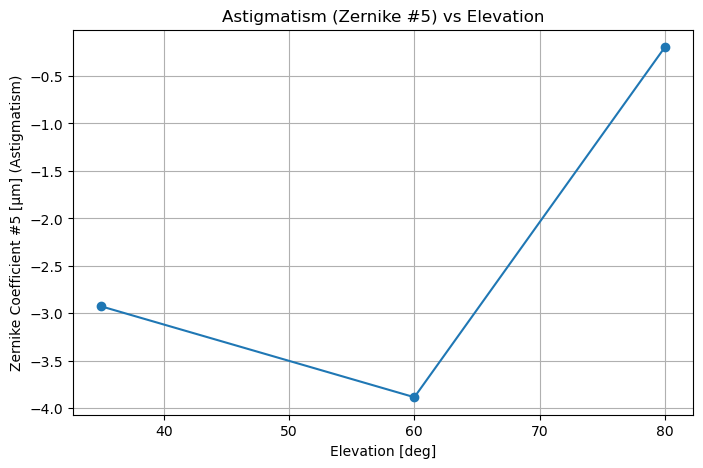

In [ ]:


# Find all mean Zernike coefficient CSV files in resultsGAMMA
csv_files = glob.glob(os.path.join('resultsGAMMA', '*zernike_coeffs_mean.csv'))

elevations = []
coeff5_values = []

for csv_file in csv_files:
    match = re.search(r'elev(\d{2})', csv_file)
    if match:
        elevation = int(match.group(1))
    else:
        continue  

    df_coeff = pd.read_csv(csv_file)

    coeff5 = df_coeff.loc[4, 'Coefficient_µm']  # index 4 for Zernike #5
    elevations.append(elevation)
    coeff5_values.append(coeff5)

    print(f"Elevation {elevation}:")
    print(df_coeff[['Noll_index', 'Name', 'Coefficient_µm']])
    print('-' * 40)
# Sort by elevation
elevations, coeff5_values = zip(*sorted(zip(elevations, coeff5_values)))

plt.figure(figsize=(8, 5))
plt.plot(elevations, coeff5_values, marker='o')
plt.xlabel('Elevation [deg]')
plt.ylabel('Zernike Coefficient #5 [µm] (Astigmatism)')
plt.title('Astigmatism (Zernike #5) vs Elevation')
plt.grid(True)
plt.show()

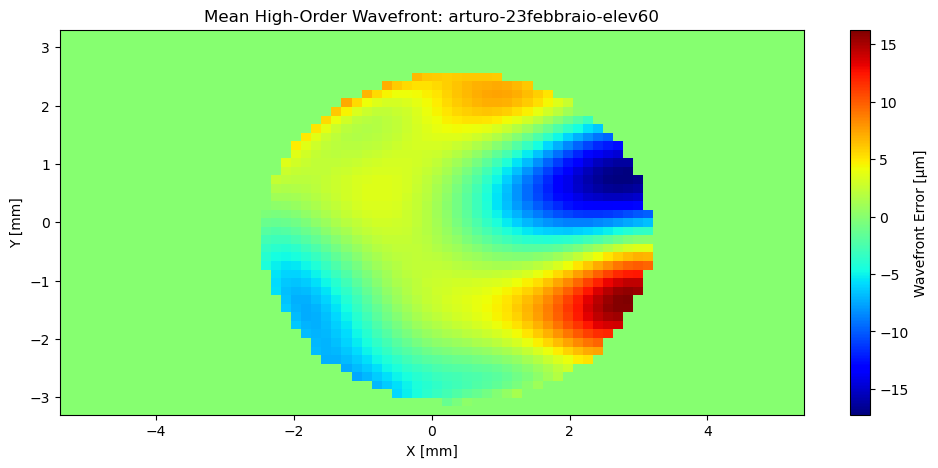

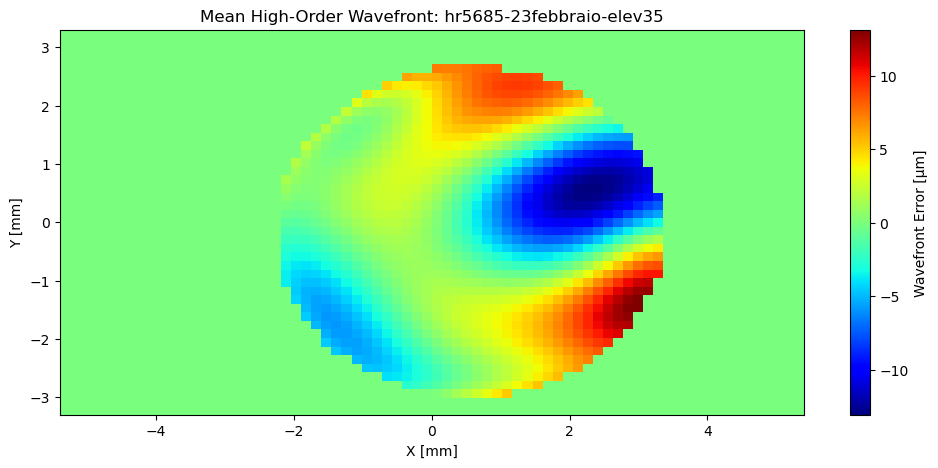

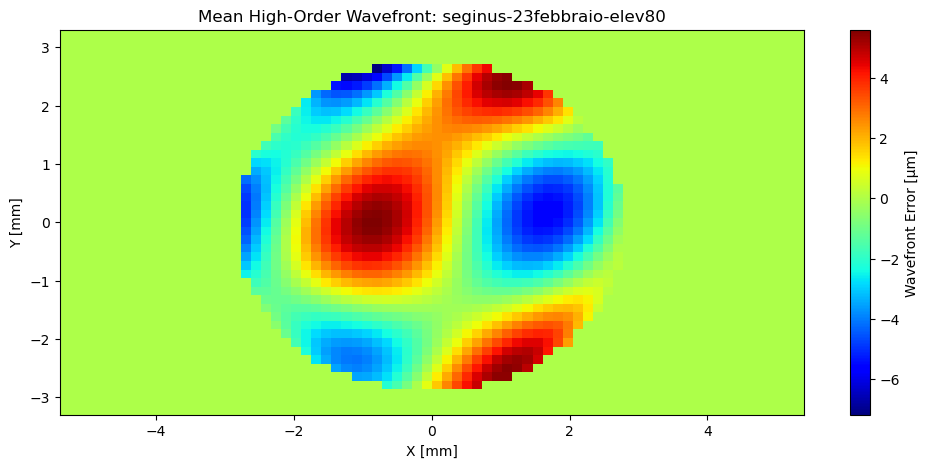

In [12]:
# Find all mean high-order wavefront FITS files in resultsGAMMA
mean_high_files = glob.glob(os.path.join('resultsGAMMA', '*wavefront_high_cube.fits'))

for fits_file in mean_high_files:
    # Read the mean high-order wavefront (first extension is the data cube)
    with fits.open(fits_file) as hdul:
        wf_high_mean = hdul[0].data[0]  # shape (Ny, Nx)
    # Try to extract the target name for the plot title
    match = re.search(r'resultsGAMMA[\\/](.*?)wavefront_high_cube\.fits', fits_file)
    target_name = match.group(1) if match else os.path.basename(fits_file)
    # Plot
    plot_wavefront_new(x_coords, y_coords, wf_high_mean, title=f"Mean High-Order Wavefront: {target_name}", cmap='jet')